<a href="https://colab.research.google.com/github/Kazantsev-Alexey/ML_DS/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D0%BF%D0%BE_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D1%82%D0%B8%D0%BA%D0%B5_%D0%BD%D0%B0_SQL%2C_Skillbox_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

In [ ]:
import pandas as pd
import psycopg2 as p
import matplotlib.pyplot as plt
import seaborn as sns

con = p.connect("dbname ='human_resources' user = 'readonly' host ='dsstudents.skillbox.ru' password ='6hajV34RTQfmxhS' port='5432'")
cur = con.cursor()
cur.execute("select * from information_schema.columns where table_name = 'hr_dataset'")
rows = cur.fetchall()
pd.DataFrame(rows).T.iloc[3]

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


0                      id
1           Employee Name
2         Employee Number
3               marriedid
4         maritalstatusid
5                genderid
6            empstatus_id
7                  deptid
8            perf_scoreid
9                     age
10               Pay Rate
11                  state
12                    zip
13                    dob
14                    sex
15            maritaldesc
16            citizendesc
17        Hispanic/Latino
18               racedesc
19           Date of Hire
20          Days Employed
21    Date of Termination
22        Reason For Term
23      Employment Status
24             department
25               position
26           Manager Name
27        Employee Source
28      Performance Score
Name: 3, dtype: object

**Гипотеза 1: рейтинг ошибок сотрудников связан с руководителем**

Качество работы руководителя можно посмотреть через оцеку работы сотрудников. На должностях с большим количеством сотрудников проще всего ориентироваться на погрешности в работе. Мы можем составить средний рейтинг ошибки сотрудников для каждого менеджера в продакшене. 

И как мы видим на графике у лучшего и худшего менеджера средний рейтинг ошибок различается почти в два раза.

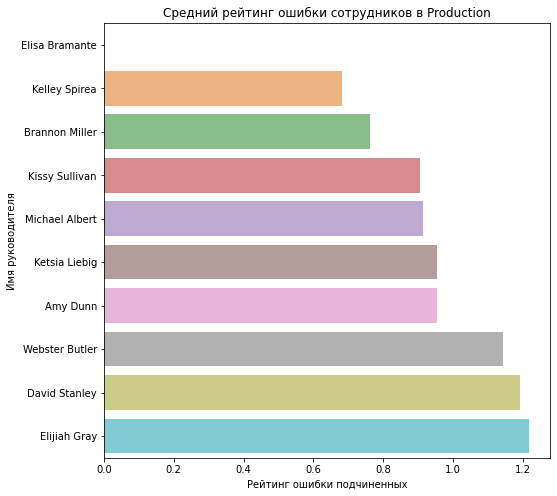

In [ ]:
cur.execute('''select "Manager Name", avg("Daily Error Rate") :: float from production_staff group by 1''')

rows = cur.fetchall()
data=pd.DataFrame(rows, columns=['Manager Name', 'Daily Error Rate']).sort_values('Daily Error Rate')
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(data=data, y='Manager Name', x='Daily Error Rate',
     ax=ax, alpha=0.6)
ax.set_xlabel('Рейтинг ошибки подчиненных')
ax.set_ylabel('Имя руководителя')

ax.set_title('Средний рейтинг ошибки сотрудников в Production')
plt.show()


**Гипотеза 2: есть связь между расой сотрудника и оценками его продуктивности**

Вполне вероятно, что раса человека связана с его карьерными успехами. Оказывать влияние могут как культурные особенности сотрудника, так и отношение его коллег. Мы можем попробовать найти связь расы человека и его дохода в компании, но наличие отделов с небольшим количество сотрудников может значительно исказить такие значения. Однако мы можем посмотреть оценку продуктивности сотрудника, значения в таком случае уже усреднены.
На графике видно, что для латиноамериканцев значительно выше процент самых низких оценок и совершенно отсутствуют оценки выше среднего и индивидуальный план развития. Также для афроамериканцев реже наблюдаются составление плана развития и оценок превышенных ожиданий. В их случае шкала состоит практически из трех ступеней.  

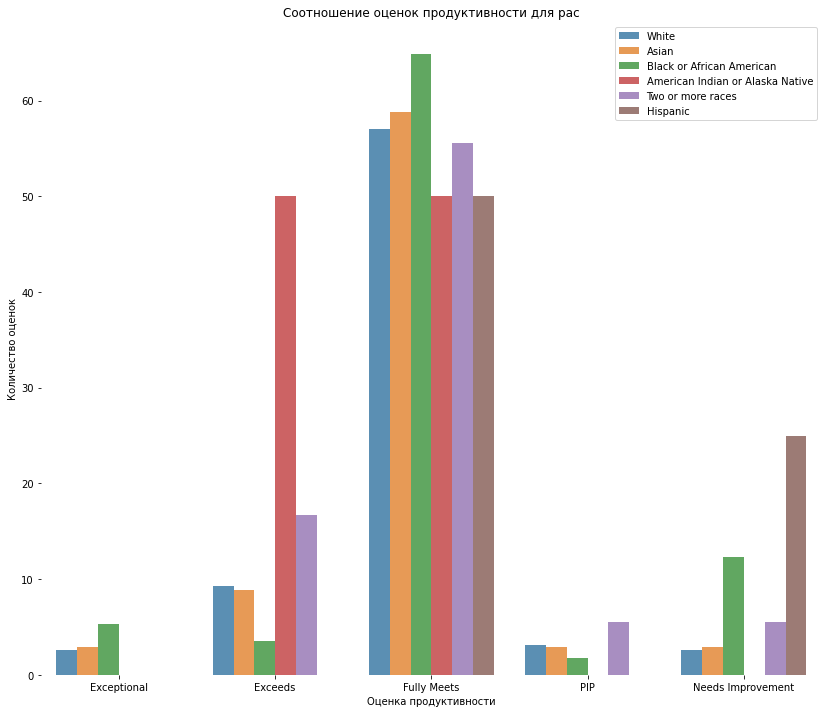

In [ ]:
cur.execute('''with a as (select "racedesc",  "Performance Score", count("id") ::float as "Scores"
                        from hr_dataset group by 1,2 order by 1),
                    b as (select "racedesc",  count("id") ::float  as "Employees"
                        from hr_dataset group by 1)
                select a."racedesc", a."Performance Score",  (a."Scores"/ b."Employees") * 100 as perc  
                from a left join b on a."racedesc" = b."racedesc"
                where a."Performance Score" not in ('90-day meets', 'N/A- too early to review') --and a."racedesc" = 'Hispanic'
                order by case when  a."Performance Score" = 'Exceptional' then 1
                            when  a."Performance Score" = 'Exceeds' then 2
                            when  a."Performance Score" = 'Fully Meets' then 3 
                            when  a."Performance Score" = 'PIP' then 4
                            when  a."Performance Score" = 'Needs improvment' then 5 END''')
rows = cur.fetchall()
data=pd.DataFrame(rows, columns=['racedesc', 'Performance Score', 'perc'])
fig, ax = plt.subplots(figsize=(14, 12))
sns.barplot(data=data, y='perc', x='Performance Score',
    hue='racedesc', ax=ax, alpha=0.8)
ax.set_xlabel('Оценка продуктивности')
ax.set_ylabel('Количество оценок')

ax.set_title('Соотношение оценок продуктивности для рас')
ax.set_frame_on(False)
ax.legend()
plt.show()

**Гипотеза 3: у сотрудников из разных подразделений есть ощутимая разница в доходе**

Очевидно, что разные навыки не оплачиваются одинаково, но с учетом того, что на одной должности тоже может быть разный оклад, не всегда очевидно, сколько денег в среднем приносит сотруднику должность. 

Здесь, например, мы видим ,что даже для сотрудника из IT есть смысл задуматься над переходом в продажи, не говоря уже про производственных специалистов.

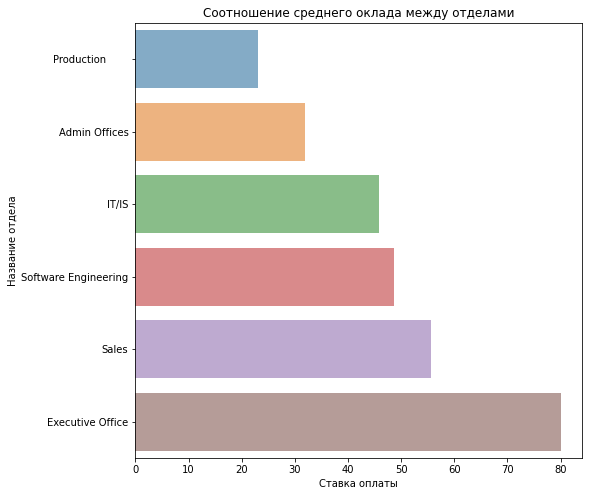

In [ ]:
cur.execute('''select  "department",  avg("Pay Rate") as "Pay Rate"
                        from hr_dataset 
                        group by 1 order by 2      	  ''')
rows = cur.fetchall()
data=pd.DataFrame(rows, columns=['department', 'Pay Rate']).sort_values('Pay Rate')
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(data=data, y='department', x='Pay Rate',
     ax=ax, alpha=0.6)
ax.set_xlabel('Ставка оплаты')
ax.set_ylabel('Название отдела')

ax.set_title('Соотношение среднего оклада между отделами')
plt.show()


**Гипотеза 4:** **процент сотрудников, достигших максимальной з/п различается между отделами**

В зависимости от сложности найти замену сотруднику, может отличаться рост его доходов в компании. На графике ниже мы видим, что лучше всего живется сетевым иженерам, они получают практически максимальное значение от вилки. И меньше всего ценятся производственные техники и помощники по административным вопросам, у которых рост з/п не значителен.

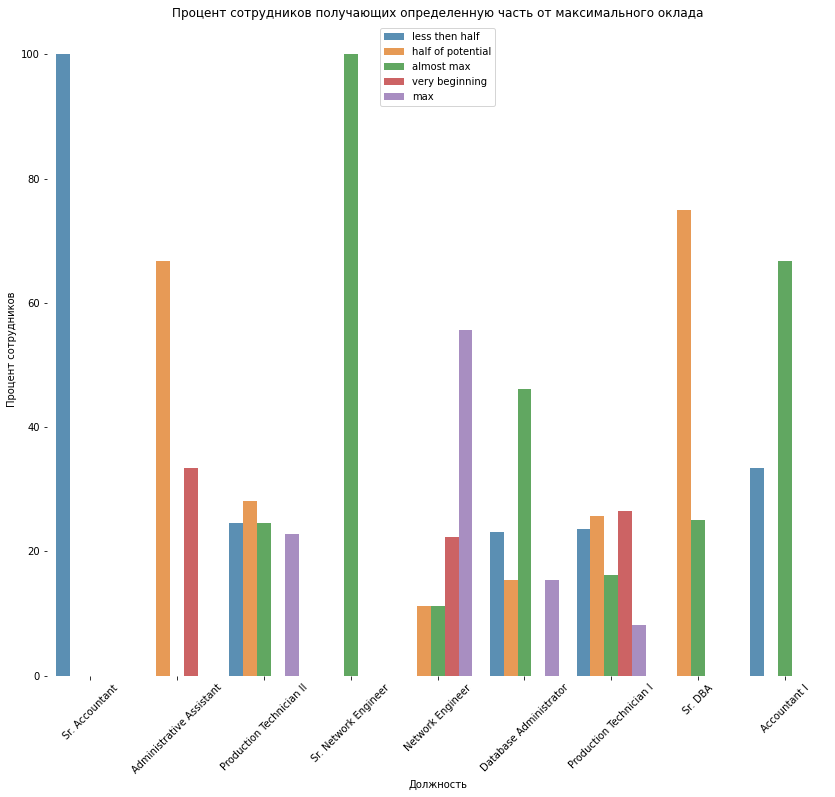

In [ ]:
cur.execute("select * from salary_grid")
cur.execute('''with a as (select  a."position", a."Days Employed", a."Pay Rate", b."Hourly Min", b."Hourly Mid", b."Hourly Max" ,
                         b."Hourly Max" - b."Hourly Min" as way, a."Pay Rate" - b."Hourly Min" part  
                         from hr_dataset a inner join salary_grid b on a."position" = b."Position"  order by 1),
                    b as (select *, part, way, case when (part/way * 100) > 95 then 'max'
                              when (part/way * 100) > 75 then 'almost max'
                              when (part/way * 100) > 50 then 'half of potential'
                              when (part/way * 100) > 25 then 'less then half'
                              else 'very beginning' end as potential from a),
                    c as (select position, potential, count(*):: float as cnt from b group by 1,2),
                    d as (select position, count(*):: float as cnt from hr_dataset group by 1)
                --select * from b where potential = 'very beginning'
                select c.*, c.cnt/d.cnt * 100 as perc from c left join d on c.position = d.position
                    order by case when c.position = 'max' then 1
                                  when c.position = 'almost max' then 2
                                  when c.position = 'half of potential' then 3
                                  when c.position = 'less then half' then 4
                                  when c.position = 'very beginning' then 5 end  ''')
rows = cur.fetchall()
data=pd.DataFrame(rows, columns=['position', 'potential', 'cnt', 'perc'])

fig, ax = plt.subplots(figsize=(14, 12))
sns.barplot(data=data, y='perc', x='position',
    hue='potential', hue_order =data['potential'].unique(), #для этого я сортировал данные в запросе
    ax=ax, alpha=0.8)
ax.set_xlabel('Должность')
ax.set_ylabel('Процент сотрудников')
plt.xticks(rotation=45)

ax.set_title('Процент сотрудников получающих определенную часть от максимального оклада')
ax.set_frame_on(False)
ax.legend()
plt.show()

**Гипотеза 5: ресурсы по поиску сотрудников неодинаковы в сравнении "затраты-эффективность"**

Разумеется все способы поиска кандидатов могут быть использованы, но их эффект различается. И мы можем посмотреть финансовые затраты в пересчете на 1 нанятого человека. В таком сравнении мы видим, что полезность careerbuilder'а может быть под вопросом, в то время как для остальных ресурсов значения хоть и отличаются, но не так заметно.

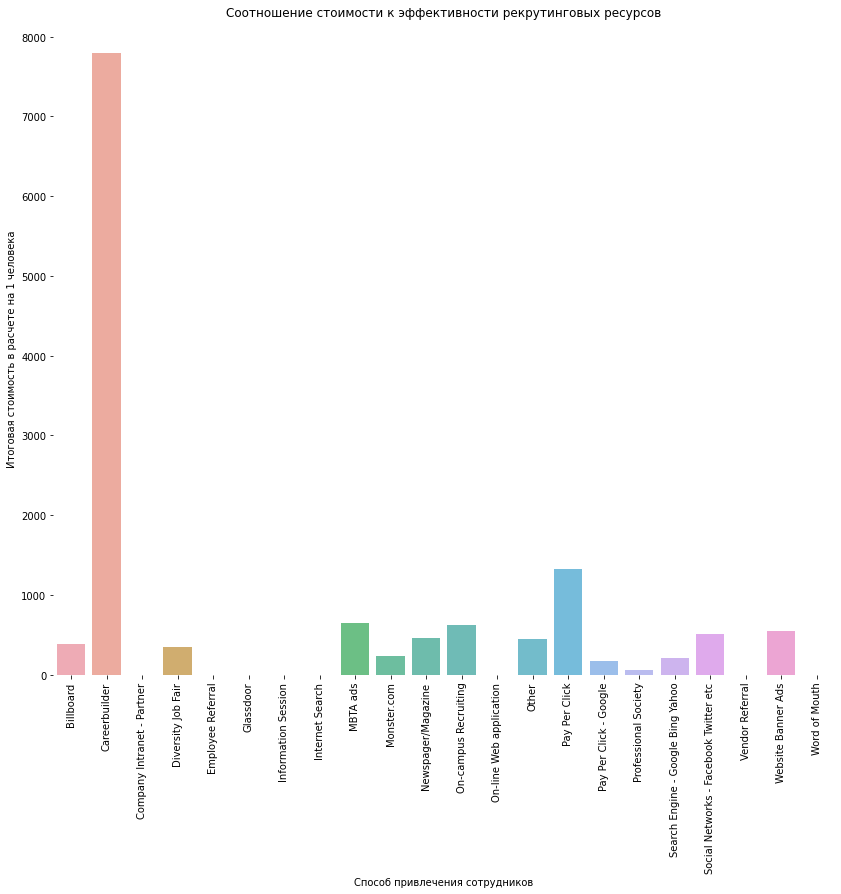

In [ ]:
cur.execute(''' with a as (select    a."Employee Source", b."Total", count(*) as cnt	 
                        from hr_dataset a inner join recruiting_costs b on a."Employee Source" = b."Employment Source"
                        group by 1,2 order by 1)
                select  "Employee Source", a."Total", cnt, a."Total"/cnt from a  ''')
rows = cur.fetchall()
data=pd.DataFrame(rows, columns=['Employee_Source', 'Total', 'cnt', 'cost'])

fig, ax = plt.subplots(figsize=(14, 12))
sns.barplot(data=data, y='cost', x='Employee_Source',
    ax=ax, alpha=0.8)
ax.set_xlabel('Способ привлечения сотрудников')
ax.set_ylabel('Итоговая стоимость в расчете на 1 человека')
plt.xticks(rotation=90)

ax.set_title('Соотношение стоимости к эффективности рекрутинговых ресурсов')
ax.set_frame_on(False)
plt.show()

**Гипотеза 6: эффективность ресурсов по подбору персонала отличается для разных отделов**

Однако, есть вероятность, что иногда надо потратить много времени и денег, чтобы найти того самого специалиста, который идеально подойдет на свою должность. Чтобы проверить это сравним результативность для каждого ресурса внутри отдела. 

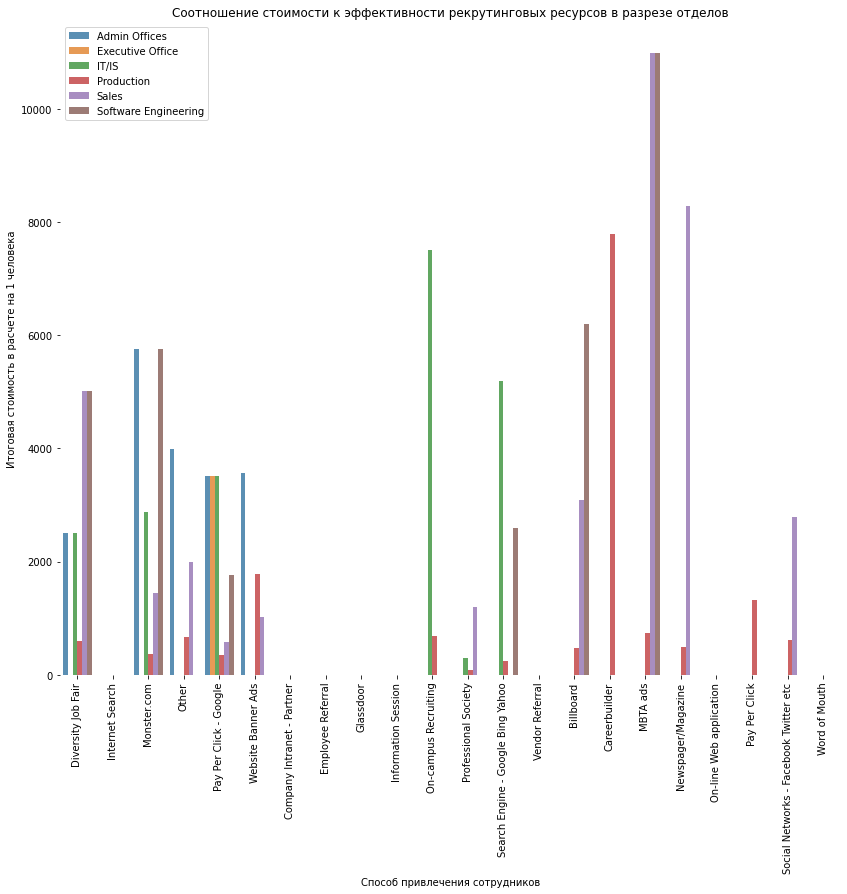

In [ ]:
cur.execute(''' with a as (select   a."department", a."Employee Source", b."Total", count(*) as cnt	 
                        from hr_dataset a inner join recruiting_costs b on a."Employee Source" = b."Employment Source"
                        group by 1,2,3 order by 1)
                select "department",  "Employee Source", a."Total", cnt, a."Total"/cnt from a  ''')
rows = cur.fetchall()
data=pd.DataFrame(rows, columns=['department', 'Employee_Source', 'Total', 'cnt', 'cost'])

fig, ax = plt.subplots(figsize=(14, 12))
sns.barplot(data=data, y='cost', x='Employee_Source',
    hue='department', #hue_order =data['potential'].unique(), #для этого я сортировал данные в запросе
    ax=ax, alpha=0.8)
ax.set_xlabel('Способ привлечения сотрудников')
ax.set_ylabel('Итоговая стоимость в расчете на 1 человека')
plt.xticks(rotation=90)

ax.set_title('Соотношение стоимости к эффективности рекрутинговых ресурсов в разрезе отделов')
ax.set_frame_on(False)
ax.legend()
plt.show()

**Рекомендации.**

Я бы порекомендовал специлистам HR отказаться от поиска человека в продажи или софт на MBTA и больше ориентироваться на Pay per Click, Monster.com  и поисковые движки. А careerbuilder не использовать вовсе, ведь на производство сотрудники итак находятся через остальные ресурсы, при этом не так затратно.

Также, есть смысл пересмотреть мотивацию сотрудников на производстве - они получают минимальные суммы от возможной вилки, а объем поиска, трудоустройства и, вероятно, обучения сотрудников тоже требует ресурсов. К тому же, ошибки на производстве влияют на качество продукции. 

В дальнейшем рекомендуется уделить больше внимания оценке продуктивности, возможно, что некоторые афроамериканцы получают несправедливо низкие или наоборот завышенные оценки.

И в заключение, я рекомендую провести ревью Дэвида Стэнли и Элайджи Грэй. Возможно, на их должность найдутся более достойные кандидаты